## Titanc Solution using LSTM network##
This is my first approach to solve the titanic Kaggle problem using LSTMs, of course improvements can be made.
The main way the algorithm works is to use all the features as a time-series data. 
I am open to comments and possible corrections on my code. 


### Frameworks
- pandas
- numpy
- seaborn 
- keras
- scikit-learn

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [243]:
train = pd.read_csv("all/train.csv", index_col = ["PassengerId"])
test = pd.read_csv("all/test.csv", index_col = ["PassengerId"])
combination = [train,test]

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data at our disposal is numerical (age, Pclass, etc.), alphabetical (name, sex & embarked) and alphanumerical (tickets). Let's get some further insight on our data:

In [244]:
train.describe(), test.describe()


(         Survived      Pclass         Age       SibSp       Parch        Fare
 count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
 mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
 std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
 min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
 25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
 50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
 75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
 max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200,
            Pclass         Age       SibSp       Parch        Fare
 count  418.000000  332.000000  418.000000  418.000000  417.000000
 mean     2.265550   30.272590    0.447368    0.392344   35.627188
 std      0.841838   14.181209    0.896760    0.981429   55.907576
 min      1.000000  

From the data above we get information regarding the various means and standard deviation of each data, furthermore we can see where we have missing values. For example in the training data set there are 714 values for the passengers' ages, however, we know that the total number of passengers is 891. 
This information will be useful later on. For now I will try to find which features will have a heavier influence on the Survival and delete those featurues that will have a lower influence on the output.

In [245]:
train[["Survived","Pclass"]].groupby("Pclass").mean()



,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [246]:
train[["Survived", "Sex"]].groupby("Sex").mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [247]:
train['groups']=pd.cut(train.Age,[0,10,20,30,40,50,60,70,80])
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,groups
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20, 30]"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30, 40]"
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20, 30]"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30, 40]"
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30, 40]"


In [248]:
train[["Survived", "groups"]].groupby("groups").mean()

,Survived
groups,
"(0, 10]",0.593750
"(10, 20]",0.382609
"(20, 30]",0.365217
"(30, 40]",0.445161
"(40, 50]",0.383721
"(50, 60]",0.404762
"(60, 70]",0.235294
"(70, 80]",0.200000


In the latter I have tried to divide the passengers by age group, by doing so we see how age has a big impact on the survival of the passenger, kids between 0-10 yrs have a higher survival rate. 

### Plotting ###
To have a better view of the data I have decided to plot it. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


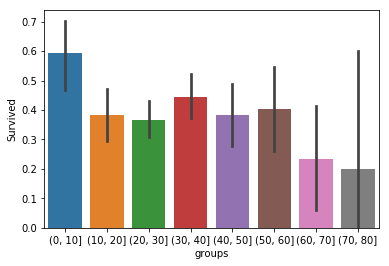

In [249]:
sns.barplot(train.groups, train.Survived)

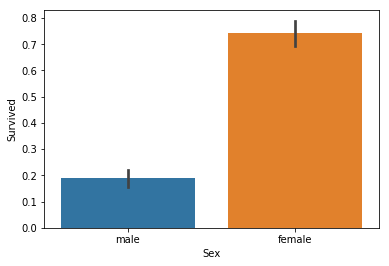

In [250]:
sns.barplot(train.Sex, train.Survived)


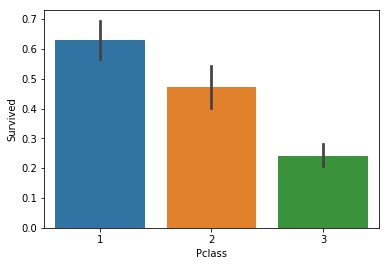

In [251]:
sns.barplot(train.Pclass, train.Survived)

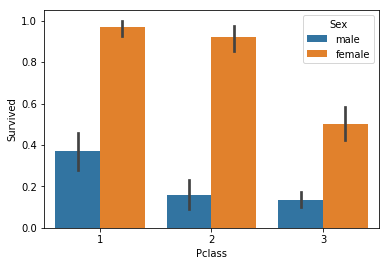

In [252]:
sns.barplot(train.Pclass, train.Survived, hue=train.Sex)

In [253]:
train.describe(include = ["O"]), test.describe(include = ["O"])

(                                  Name   Sex    Ticket Cabin Embarked
 count                              891   891       891   204      889
 unique                             891     2       681   147        3
 top     Kalvik, Mr. Johannes Halvorsen  male  CA. 2343    G6        S
 freq                                 1   577         7     4      644,
                    Name   Sex    Ticket            Cabin Embarked
 count               418   418       418               91      418
 unique              418     2       363               76        3
 top     Sap, Mr. Julius  male  PC 17608  B57 B59 B63 B66        S
 freq                  1   266         5                3      270)

For this version I have decided to delete the data regarding names, cabin and tickets. Cabin has many N/A values, names may not be directly related to the survival rate, however, their title could be relevant for future evaluations. In this case the name values are dropped, but in the future it could be interesting keeping the title of each passenger. 

In [254]:
train=train.drop(["Name", "Ticket","Cabin", "groups"], axis=1)
test=test.drop(["Name", "Ticket","Cabin"], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Converting Data and filling missing data
Sex are either male or females, hence we will convert this data to 1s and 0s respectively. Same thing can be applied to the embarked feature [0,1,2]. 

In [255]:
male_female = {"male":1,
              "female":0}

train["Sex"]=train["Sex"].map(male_female)
test["Sex"]=test["Sex"].map(male_female)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,S
2,1,1,0,38.0,1,0,71.2833,C
3,1,3,0,26.0,0,0,7.9250,S
4,1,1,0,35.0,1,0,53.1000,S
5,0,3,1,35.0,0,0,8.0500,S


In [256]:
embar = {"C":2,
        "S":1,
        "Q": 0}
train["Embarked"]=train["Embarked"].map(embar)
test["Embarked"]=test["Embarked"].map(embar)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,1.0
2,1,1,0,38.0,1,0,71.2833,2.0
3,1,3,0,26.0,0,0,7.9250,1.0
4,1,1,0,35.0,1,0,53.1000,1.0
5,0,3,1,35.0,0,0,8.0500,1.0


In [257]:

train["Age"]=train["Age"].fillna(value=np.mean(train["Age"]))
test["Age"]=test["Age"].fillna(value=np.mean(train["Age"]))
test["Fare"]=test["Fare"].fillna(value=np.mean(train["Fare"]))
train["Embarked"]=train["Embarked"].fillna(value=round(np.mean(train["Embarked"])))


## Model ##
Extracting data

In [258]:
train_y = train["Survived"].iloc[:].values
train_x = train.drop(["Survived"], axis = 1).iloc[:,:].values

train_x = train_x.reshape(train_x.shape[0],-1,1)
train_x.shape

(891, 7, 1)

LSTM parameters

In [259]:
batch_size = 11
epoch = 20
hidden_units = 256 

LSTM architecture

In [260]:
model = Sequential()
model.add(LSTM(hidden_units, input_shape=train_x.shape[1:],batch_size=batch_size))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss = 'mean_squared_error',metrics = ['accuracy'] )
model.fit(train_x,train_y, batch_size=batch_size, epochs=epoch, verbose = 1)


Epoch 1/20
891/891 [==============================] - 3s 3ms/step - loss: 0.3073 - acc: 0.5881
Epoch 2/20
891/891 [==============================] - 2s 2ms/step - loss: 0.2137 - acc: 0.6577
Epoch 3/20
891/891 [==============================] - 2s 2ms/step - loss: 0.2091 - acc: 0.6790
Epoch 4/20
891/891 [==============================] - 2s 2ms/step - loss: 0.2081 - acc: 0.6779
Epoch 5/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1979 - acc: 0.7149
Epoch 6/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1777 - acc: 0.7497
Epoch 7/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1633 - acc: 0.7710
Epoch 8/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1555 - acc: 0.8002
Epoch 9/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1518 - acc: 0.7834
Epoch 10/20
891/891 [==============================] - 2s 2ms/step - loss: 0.1499 - acc: 0.7935
Epoch 11/20
891/891 [============================

In [261]:
out = pd.read_csv("all/gender_submission.csv", index_col = ["PassengerId"])
y_test = out.iloc[:].values

In [262]:
test_x = test.iloc[:,:].values
test_x = test_x.reshape(test_x.shape[0],-1,1)
scores = model.evaluate(test_x, y_test, batch_size=batch_size)
predictions = model.predict(test_x, batch_size = batch_size)


418/418 [==============================] - 0s 1ms/step


In [263]:

print('LSTM test accuracy:', scores[1])

LSTM test accuracy: 0.899521540654333
